Reference to baseline study: https://www.bloomberg.com/company/announcements/can-machine-learning-predict-a-hit-or-miss-on-estimated-earnings/
# LSTM Demonstration

## Part 1: Architecture

<img src=LSTM_diag.png>

- Recurrence levels: 200

- Inputs are encoded into 11x1 vectors containing real values in [0, 1] interval.

- Output is a scalar value

- 2nd layer is logistic regression that takes intermediate representation given by lstm and returns binary classification.


## Test and Training Approach

- There are 143,297 combined stock records, each with 11 attributes after preprocessing.
- Holdout Crossvalidation is implemented by splitting data into training and test sets with 60-40 ratio
- No hyperparamter optimization was performed.
- Took >10 hours to train


## Part 3: Code

### Preprocess and test train split:
- read records
- builds list of input and output sequences for the model
- splits into train and test sets

In [3]:
%matplotlib inline
from glob import glob
import warnings
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cross_validation, metrics
dtype=theano.config.floatX='float64'
    
ohlcvList = glob("./stocks/*combined.csv")
ohlcvList.sort() # for consistentency

X = pd.DataFrame()
for ohlcv in ohlcvList:
    x = pd.read_csv(ohlcv)
    X = pd.concat([X,x],axis=0)

X = X.drop(['date.1'],axis=1) # drop redundant date attr
X = X.drop(['ticker'],axis=1) # drop company name

X['date'] = pd.to_datetime(X['date'],  format='%Y-%m-%d') # read as date
X['date'] = X['date'].astype(np.int64) # convert to unix date
X['fiscal_quarter'] = X['fiscal_quarter'].astype('category') 
    
X = pd.concat([X,pd.get_dummies(X['fiscal_quarter'])], axis=1)
X = X.drop(['fiscal_quarter'], axis=1)

y = X['beat']
X = X.drop(['beat'],axis=1)
X = X/X.max().astype(dtype)
X = X.as_matrix()
y = y.as_matrix()

# Randomly sample and split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)

print 'Dataset loaded'         

Dataset loaded


### Build LSTM Model:

( Borrowed from: http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/LSTM.php )

In [ ]:
warnings.filterwarnings("ignore") # will hide depreciation warning

sigma = lambda x: 1 / (1 + T.exp(-x))

act = T.tanh

# sequences: x_t
# prior results: h_tm1, c_tm1
# non-sequences: W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xy, W_hy, W_cy, b_y
def one_lstm_step(x_t, h_tm1, c_tm1, W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xy, W_ho, W_cy, b_o, W_hy, b_y):
    i_t = sigma(theano.dot(x_t, W_xi) + theano.dot(h_tm1, W_hi) + theano.dot(c_tm1, W_ci) + b_i)
    f_t = sigma(theano.dot(x_t, W_xf) + theano.dot(h_tm1, W_hf) + theano.dot(c_tm1, W_cf) + b_f)
    c_t = f_t * c_tm1 + i_t * act(theano.dot(x_t, W_xc) + theano.dot(h_tm1, W_hc) + b_c) 
    o_t = sigma(theano.dot(x_t, W_xo)+ theano.dot(h_tm1, W_ho) + theano.dot(c_t, W_co)  + b_o)
    h_t = o_t * act(c_t)
    y_t = sigma(theano.dot(h_t, W_hy) + b_y) 
    return [h_t, c_t, y_t]
    

def sample_weights(sizeX, sizeY):
    values = np.ndarray([sizeX, sizeY], dtype=dtype)
    for dx in xrange(sizeX):
        vals = np.random.uniform(low=-1., high=1.,  size=(sizeY,))
        #vals_norm = np.sqrt((vals**2).sum())
        #vals = vals / vals_norm
        values[dx,:] = vals
    _,svs,_ = np.linalg.svd(values)
    #svs[0] is the largest singular value                      
    values = values / svs[0]
    return values  
    

n_in = 11 # input vector size
n_hidden = n_i = n_c = n_o = n_f = 200
n_y = 1 # output vector size

# initialize weights
# i_t and o_t should be "open" or "closed"
# f_t should be "open" (don't forget at the beginning of training)
# we try to archive this by appropriate initialization of the corresponding biases 

W_xi = theano.shared(sample_weights(n_in, n_i))  
W_hi = theano.shared(sample_weights(n_hidden, n_i))  
W_ci = theano.shared(sample_weights(n_c, n_i))  
b_i = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_i)))
W_xf = theano.shared(sample_weights(n_in, n_f)) 
W_hf = theano.shared(sample_weights(n_hidden, n_f))
W_cf = theano.shared(sample_weights(n_c, n_f))
b_f = theano.shared(np.cast[dtype](np.random.uniform(0, 1.,size = n_f)))
W_xc = theano.shared(sample_weights(n_in, n_c))  
W_hc = theano.shared(sample_weights(n_hidden, n_c))
b_c = theano.shared(np.zeros(n_c, dtype=dtype))
W_xo = theano.shared(sample_weights(n_in, n_o))
W_ho = theano.shared(sample_weights(n_hidden, n_o))
W_co = theano.shared(sample_weights(n_c, n_o))
b_o = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_o)))
W_hy = theano.shared(sample_weights(n_hidden, n_y))
b_y = theano.shared(np.zeros(n_y, dtype=dtype))

c0 = theano.shared(np.zeros(n_hidden, dtype=dtype))
h0 = T.tanh(c0)

params = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xo, W_ho, W_co, b_o, W_hy, b_y, c0]

#first dimension is time

#input 
v = T.matrix(dtype=dtype)

# target
target = T.matrix(dtype=dtype)

# hidden and outputs of the entire sequence
[h_vals, _, y_vals], _ = theano.scan(fn=one_lstm_step, 
                                  sequences = dict(input=v, taps=[0]), 
                                  outputs_info = [h0, c0, None ], # corresponds to return type of fn
                                  non_sequences = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xo, W_ho, W_co, b_o, W_hy, b_y] )

# Criss-entropy cost function chosen for multiclass classification
#cost =  T.mean((target - y_vals) ** 2) #-T.mean(target * T.log(y_vals)+ (1.- target) * T.log(1. - y_vals)) * T.abs_(target-y_vals)
cost = -T.mean(target * T.log(y_vals) + (1.- target) * T.log(1. - y_vals))

# learning rate
lr = np.cast[dtype](.1)
learning_rate = theano.shared(lr)

gparams = []
for param in params:
  gparam = T.grad(cost, param)
  gparams.append(gparam)

updates=[]
for param, gparam in zip(params, gparams):
    updates.append((param, param - gparam * learning_rate))
    
learn_rnn_fn = theano.function(inputs = [v, target],
                               outputs = cost,
                               updates = updates)
                               
predictions = theano.function(inputs = [v], outputs = y_vals)


## Part 4: Training and Evaluation
### Training with SGD optimzer and Plot training progress:

epoch:1/100 loss:54725.7184
epoch:2/100 loss:54314.1081
epoch:3/100 loss:54246.8391
epoch:4/100 loss:53564.5580
epoch:5/100 loss:53697.7504
epoch:6/100 loss:53739.6116
epoch:7/100 loss:53573.2803
epoch:8/100 loss:53552.2042
epoch:9/100 loss:53442.1418
epoch:10/100 loss:53338.1950
epoch:11/100 loss:53369.9025
epoch:12/100 loss:53302.2991
epoch:13/100 loss:53100.8933
epoch:14/100 loss:53264.5963
epoch:15/100 loss:53201.5169
epoch:16/100 loss:53054.0799
epoch:17/100 loss:52946.3432
epoch:18/100 loss:52802.1768
epoch:19/100 loss:52998.0007
epoch:20/100 loss:52779.1717
epoch:21/100 loss:52644.1560
epoch:22/100 loss:52709.0167
epoch:23/100 loss:52753.1338
epoch:24/100 loss:52425.8084
epoch:25/100 loss:52522.4759
epoch:26/100 loss:52513.3829
epoch:27/100 loss:52465.7611
epoch:28/100 loss:52561.2885
epoch:29/100 loss:52538.6326
epoch:30/100 loss:52391.9070
epoch:31/100 loss:52080.0992
epoch:32/100 loss:52294.5273
epoch:33/100 loss:52289.9992
epoch:34/100 loss:52191.6114
epoch:35/100 loss:52217

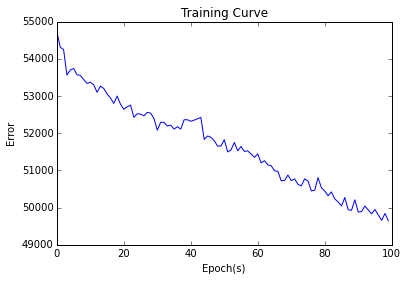

In [17]:
nb_epochs=100
train_errors = []
  
def train_rnn():
    print "Started training"
    for x in range(nb_epochs):
        error = 0.
        for j in range(len(X_train)):
            index = np.random.randint(0, len(X_train))
            i = np.matrix(X_train[index,:])
            o = np.matrix([y_train[index]])
            train_cost = learn_rnn_fn(i, o)
            error += train_cost
        train_errors.append(error)
        print "epoch:%d/%d loss:%.4f" %(x+1,nb_epochs, error)
        
train_rnn()

plt.plot(range(len(train_errors)), train_errors, 'b-')
plt.title('Training Curve')
plt.xlabel('Epoch(s)')
plt.ylabel('Error')
plt.show()


Observation: The downward trend may indicate that the model was able to fit the data

### Evaluation on Test Set:

In [19]:
round_vec = np.vectorize(round)
y_pred = round_vec(predictions(X_test))

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1score = metrics.f1_score(y_test, y_pred)

confmat = metrics.confusion_matrix(y_test, y_pred)

print 'Confusion matrix:'
print confmat
print '\nAccuracy: %.2f%%' %(acc * 100)
print 'Precision score: %.2f%%'%(prec * 100)
print 'Recall score %.2f%%'%(recall * 100)
print 'F1 Score: %.2f%%'%(f1score * 100)



Confusion matrix:
[[ 2167 16759]
 [  969 37424]]

Accuracy: 69.07%
Precision score: 69.07%
Recall score 97.48%
F1 Score: 80.85%

